In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/gender_submission.csv
/kaggle/input/titanic/test.csv


loading libraries

In [2]:
import seaborn as sns
from collections import Counter
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
SEED=2020
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.combine import SMOTETomek
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
ss = StandardScaler()

Let's load datasets

In [3]:
train = pd.read_csv('/kaggle/input/titanic/train.csv')
test = pd.read_csv('/kaggle/input/titanic/test.csv')

## thanks to @Nadezda Demidova  https://www.kaggle.com/demidova/titanic-eda-tutorial-with-seaborn
train.loc[train['PassengerId'] == 631, 'Age'] = 48

# Passengers with wrong number of siblings and parch
train.loc[train['PassengerId'] == 69, ['SibSp', 'Parch']] = [0,0]
test.loc[test['PassengerId'] == 1106, ['SibSp', 'Parch']] = [0,0]
## to reduce the amount of code let's introduce a general frame
full_data = [train, test]


In [4]:
## train dataset overview
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


first of all let's find and drop outliers (but with outlier step 1.7 * IQR for best perfomance)...

In [5]:
def detect_outliers(df,n,features):
    """
    Takes a dataframe df of features and returns a list of the indices
    corresponding to the observations containing more than n outliers according
    to the Tukey method.
    """
    outlier_indices = []
    
    # iterate over features(columns)
    for col in features:
        # 1st quartile (25%)
        Q1 = np.percentile(df[col], 25)
        # 3rd quartile (75%)
        Q3 = np.percentile(df[col],75)
        # Interquartile range (IQR)
        IQR = Q3 - Q1
        
        # outlier step
        outlier_step = 1.7 * IQR
        
        # Determine a list of indices of outliers for feature col
        outlier_list_col = df[(df[col] < Q1 - outlier_step) | (df[col] > Q3 + outlier_step )].index
        
        # append the found outlier indices for col to the list of outlier indices 
        outlier_indices.extend(outlier_list_col)
        
    # select observations containing more than 2 outliers
    outlier_indices = Counter(outlier_indices)        
    multiple_outliers = list( k for k, v in outlier_indices.items() if v > n )
    
    return multiple_outliers   

#detect outliers from Age, SibSp , Parch and Fare
Outliers_to_drop = detect_outliers(train,2,["Age","SibSp","Parch","Fare"])
train.loc[Outliers_to_drop] # Show the outliers rows


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
27,28,0,1,"Fortune, Mr. Charles Alexander",male,19.0,3,2,19950,263.0,C23 C25 C27,S
88,89,1,1,"Fortune, Miss. Mabel Helen",female,23.0,3,2,19950,263.0,C23 C25 C27,S
341,342,1,1,"Fortune, Miss. Alice Elizabeth",female,24.0,3,2,19950,263.0,C23 C25 C27,S


(outliers by Fare feature)

In [6]:
train = train.drop(Outliers_to_drop, axis = 0).reset_index(drop=True)

Missing and unique values overview...

In [7]:
## train dataset overview

def basic_details(df):
    b = pd.DataFrame()
    b['Missing value, %'] = round(df.isnull().sum()/df.shape[0]*100)
    b['N unique value'] = df.nunique()
    b['dtype'] = df.dtypes
    return b

basic_details(train)

,"Missing value, %",N unique value,dtype
PassengerId,0.0,888,int64
Survived,0.0,2,int64
Pclass,0.0,3,int64
Name,0.0,888,object
Sex,0.0,2,object
Age,20.0,87,float64
SibSp,0.0,7,int64
Parch,0.0,7,int64
Ticket,0.0,681,object
Fare,0.0,248,float64


the same for test dataset...

In [8]:
basic_details(test)

,"Missing value, %",N unique value,dtype
PassengerId,0.0,418,int64
Pclass,0.0,3,int64
Name,0.0,418,object
Sex,0.0,2,object
Age,21.0,79,float64
SibSp,0.0,7,int64
Parch,0.0,8,int64
Ticket,0.0,363,object
Fare,0.0,169,float64
Cabin,78.0,76,object


First of all let's arrange missing values, and I decided to drop Cabin feature due to 77% of missing values.
As for Age feature - just make simple imputation

In [9]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 888 entries, 0 to 887
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  888 non-null    int64  
 1   Survived     888 non-null    int64  
 2   Pclass       888 non-null    int64  
 3   Name         888 non-null    object 
 4   Sex          888 non-null    object 
 5   Age          711 non-null    float64
 6   SibSp        888 non-null    int64  
 7   Parch        888 non-null    int64  
 8   Ticket       888 non-null    object 
 9   Fare         888 non-null    float64
 10  Cabin        201 non-null    object 
 11  Embarked     886 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.4+ KB


In [10]:
full_data = [train, test]

for df in full_data:
    df["Age"] = df["Age"].fillna(df["Age"].median())
    df['Has_Cabin'] = df["Cabin"].apply(lambda x: 0 if type(x) == float else 1)
    df.drop(["PassengerId", 'Cabin'], axis=1, inplace=True)
## and we have 2 NaN in train dataser for Embarked feature, so let's impute it with most frequent value 'S'
train["Embarked"] = train["Embarked"].fillna("S")


In [11]:
## the same for test dataset
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 10 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Pclass     418 non-null    int64  
 1   Name       418 non-null    object 
 2   Sex        418 non-null    object 
 3   Age        418 non-null    float64
 4   SibSp      418 non-null    int64  
 5   Parch      418 non-null    int64  
 6   Ticket     418 non-null    object 
 7   Fare       417 non-null    float64
 8   Embarked   418 non-null    object 
 9   Has_Cabin  418 non-null    int64  
dtypes: float64(2), int64(4), object(4)
memory usage: 32.8+ KB


In [12]:
#we have 1 NaN in test dataser for Fare feature, so let's impute it...
test['Fare'].fillna(test["Fare"].median(), inplace=True)

In [13]:
## Has_Cabin feature survival rate
train[["Has_Cabin", "Survived"]].groupby(['Has_Cabin'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,Has_Cabin,Survived
1,1,0.666667
0,0,0.299854


In [14]:
## checking for Embarked feature distribution before we'll make it numerical
train[["Embarked", "Survived"]].groupby(['Embarked'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,Embarked,Survived
0,C,0.553571
1,Q,0.389610
2,S,0.337481


Note: C = Cherbourg, Q = Queenstown, S = Southampton

**So Cherbourg has high survival rate**

In [15]:
## Making from categorial Embarked -  numerical feature
for df in full_data:
    df["Embarked"][df["Embarked"] == "S"] = 1
    df["Embarked"][df["Embarked"] == "C"] = 2
    df["Embarked"][df["Embarked"] == "Q"] = 3
    df["Embarked"] = df["Embarked"].astype(int)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-

so we've imputed all NaNs and lets start with feature engeneering....

In [16]:
## new feature Name length, later we will check it's influence on target
for df in full_data:
    df['Name_length'] = df['Name'].apply(len)

# New Title feature
title_mapping = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Rare": 5}
for df in full_data:
    df['Title'] = df.Name.str.extract(' ([A-Za-z]+)\.', expand=False)
    df['Title'] = df['Title'].replace(['Lady', 'Countess','Capt', 'Col', 'Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
    df['Title'] = df['Title'].replace('Mlle', 'Miss')
    df['Title'] = df['Title'].replace('Ms', 'Miss')
    df['Title'] = df['Title'].replace('Mme', 'Mrs')
    df['Title'] = df['Title'].map(title_mapping)
    df['Title'] = df['Title'].fillna(0)


##dropping Name feature from both datasets
for df in full_data:
    df.drop(['Name'], axis=1,inplace=True)


In [17]:
# Convert 'Sex' variable to integer form
for df in full_data:
    df["Sex"][df["Sex"] == "male"] = 1
    df["Sex"][df["Sex"] == "female"] = 0
    df["Sex"] = df["Sex"].astype(int)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [18]:
# New 'FamilySize' feature
for df in full_data:
    df['FamilySize'] = df['SibSp'] + df['Parch'] + 1


In [19]:
## checking for Survived dependence of FamilySize feature
train[["FamilySize", "Survived"]].groupby(['FamilySize'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,FamilySize,Survived
3,4,0.724138
2,3,0.578431
1,2,0.552795
0,1,0.304833
6,7,0.272727
4,5,0.200000
5,6,0.052632
7,8,0.000000
8,11,0.000000


I see high survival rate in families with 2, 3 and 4 members...Let's see plots

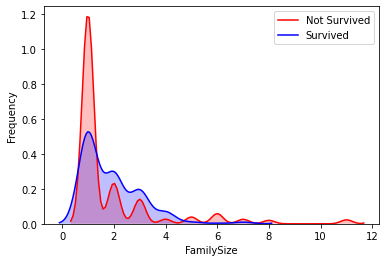

In [20]:
# FamilySize distribution
g = sns.kdeplot(train['FamilySize'][(train["Survived"] == 0) & (train['FamilySize'].notnull())], color="Red", shade = True)
g = sns.kdeplot(train['FamilySize'][(train["Survived"] == 1) & (train['FamilySize'].notnull())], ax =g, color="Blue", shade= True)
g.set_xlabel('FamilySize')
g.set_ylabel("Frequency")
g = g.legend(["Not Survived","Survived"])

Conclusions:
* Alone passangers have low survival rate
* Passengers in families with more than 4 members have low survival rate
* High survival rate have passengers in families with 2, 3 and 4 members

In [21]:
## making new FamilySize_cat feature based on above mentioned conclusion and let's see its distribution
bins = [0,1,4,11]
labels=[0,1,2]
train['FamilySize_cat'] = pd.cut(train['FamilySize'], bins=bins, labels=labels)
test['FamilySize_cat'] = pd.cut(test['FamilySize'], bins=bins, labels=labels)
train[["FamilySize_cat", "Survived"]].groupby(['FamilySize_cat'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,FamilySize_cat,Survived
1,1,0.578767
0,0,0.304833
2,2,0.120690


Next feature for review - Name_lenght, let's see for its distribution...

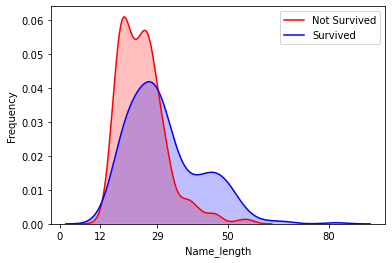

In [22]:
plt.xticks([0,12,29,50, 80])

g = sns.kdeplot(train['Name_length'][(train["Survived"] == 0) & (train['Name_length'].notnull())], color="Red", shade = True)
g = sns.kdeplot(train['Name_length'][(train["Survived"] == 1) & (train['Name_length'].notnull())], ax =g, color="Blue", shade= True)
g.set_xlabel('Name_length')
g.set_ylabel("Frequency")
g = g.legend(["Not Survived","Survived"])


**Passengers with Name_length not more than 29 letters have low survival rate: 60% vs 30% (see below)**

In [23]:
## let's make new cat feature based on this conclusion:

bins = [11,29,100]
labels=[0,1]
train['Name_length_cat'] = pd.cut(train['Name_length'], bins=bins, labels=labels)
test['Name_length_cat'] = pd.cut(test['Name_length'], bins=bins, labels=labels)
train[["Name_length_cat", "Survived"]].groupby(['Name_length_cat'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,Name_length_cat,Survived
1,1,0.599222
0,0,0.294770


60% vs 30%!!!

**Next feature Age review**

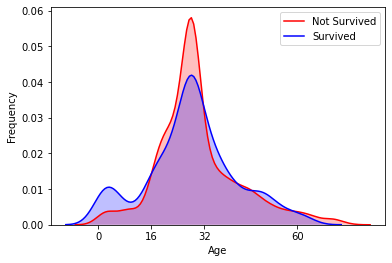

In [24]:
plt.xticks([0,16,32,60,100])

g = sns.kdeplot(train['Age'][(train["Survived"] == 0) & (train['Age'].notnull())], color="Red", shade = True)
g = sns.kdeplot(train['Age'][(train["Survived"] == 1) & (train['Age'].notnull())], ax =g, color="Blue", shade= True)
g.set_xlabel('Age')
g.set_ylabel("Frequency")
g = g.legend(["Not Survived","Survived"])

Some conclusions:
* Children till 16 years old have hight survival rate
* Passengers from 17 till 32 and up from 60 years old have low survival rate

In [25]:
## new Age_cat feature based on this conclusions
bins = [0,16,32,60,100]
labels=[0,1,2,3]
train['Age_cat'] = pd.cut(train['Age'], bins=bins, labels=labels)
test['Age_cat'] = pd.cut(test['Age'], bins=bins, labels=labels)
train[["Age_cat", "Survived"]].groupby(['Age_cat'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,Age_cat,Survived
0,0,0.550000
2,2,0.417004
1,1,0.342308
3,3,0.190476


Ticket feature

In [26]:
for df in full_data:
    df['Ticket'] = df['Ticket'].apply(len)

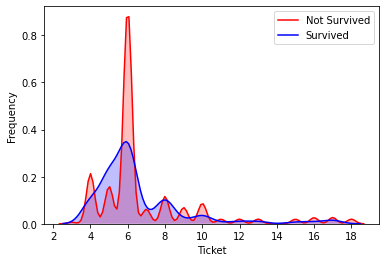

In [27]:
g = sns.kdeplot(train['Ticket'][(train["Survived"] == 0) & (train['Ticket'].notnull())], color="Red", shade = True)
g = sns.kdeplot(train['Ticket'][(train["Survived"] == 1) & (train['Ticket'].notnull())], ax =g, color="Blue", shade= True)
g.set_xlabel('Ticket')
g.set_ylabel("Frequency")
g = g.legend(["Not Survived","Survived"])

Seems tickets with lenght of 6 digits have low survival rate and with len of 5 digits vice versa

In [28]:
for df in full_data:
    df['Ticket_5'] = train['Ticket'].map(lambda x: 1 if x == 5 else 0)
    df['Ticket_6'] = train['Ticket'].map(lambda x: 1 if x == 6 else 0)

train[["Ticket_5", "Survived"]].groupby(['Ticket_5'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,Ticket_5,Survived
1,1,0.617188
0,0,0.343421


In [29]:
train[["Ticket_6", "Survived"]].groupby(['Ticket_6'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,Ticket_6,Survived
0,0,0.439232
1,1,0.319809


**Fare feature analysis**

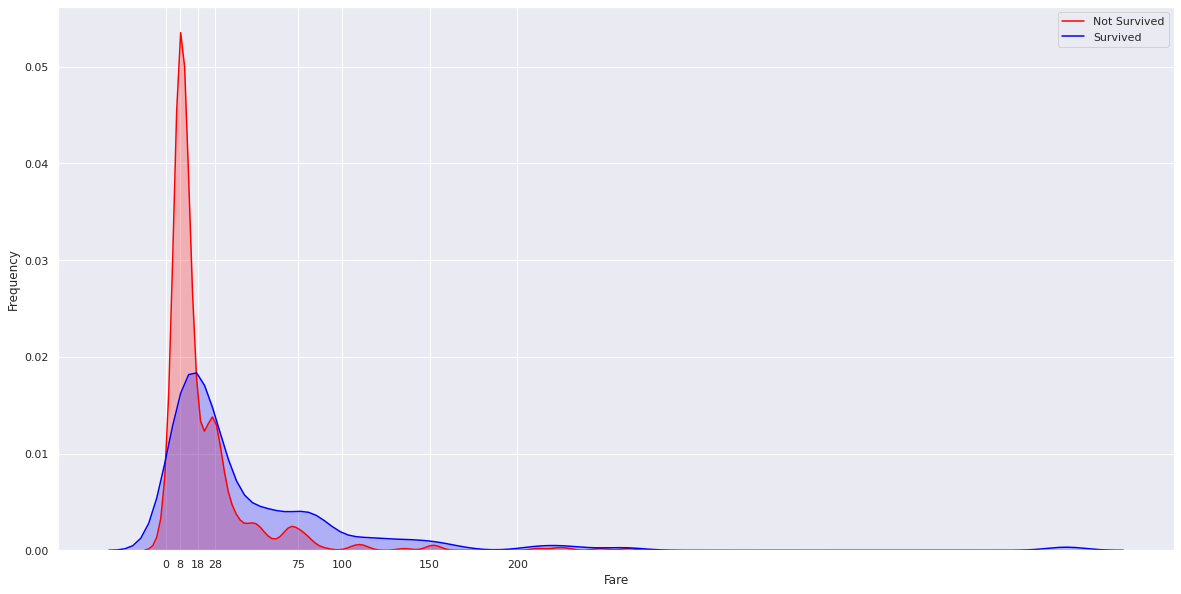

In [30]:
sns.set(rc={'figure.figsize':(20,10)})
plt.xticks([0,8,18,28,75,100,150,200])



g = sns.kdeplot(train['Fare'][(train["Survived"] == 0) & (train['Fare'].notnull())], color="Red", shade = True)
g = sns.kdeplot(train['Fare'][(train["Survived"] == 1) & (train['Fare'].notnull())], ax =g, color="Blue", shade= True)
g.set_xlabel('Fare')
g.set_ylabel("Frequency")
g = g.legend(["Not Survived","Survived"])

In [31]:
## making bins based on picture info for new feature Fare_cat
bins = [-1,8,18,28,520]
labels=[0,1,2,3]
train['Fare_cat'] = pd.cut(train['Fare'], bins=bins, labels=labels)
test['Fare_cat'] = pd.cut(test['Fare'], bins=bins, labels=labels)
train[["Fare_cat", "Survived"]].groupby(['Fare_cat'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,Fare_cat,Survived
3,3,0.570281
2,2,0.474453
1,1,0.310345
0,0,0.215768


In [32]:
features_to_drop = ['Age','Fare','SibSp', 'Parch', 'Ticket', 'Name_length', 'FamilySize']
for df in full_data:
    df["FamilySize_cat"] = df["FamilySize_cat"].astype(int)
    df["Age_cat"] = df["Age_cat"].astype(int)
    df["Fare_cat"] = df["Fare_cat"].astype(int)
    df["Name_length_cat"] = df["Name_length_cat"].astype(int)
    df['Age_scaled'] = ss.fit_transform(df['Age'].values.reshape(-1,1)) ## new feature based on Age
    df['Fare_scaled'] = ss.fit_transform(df['Fare'].values.reshape(-1,1)) ## new feature based on Fare
    df['Name_length_log'] = np.log1p(df['Name_length']) # new normalized feature on base of Name_lenght 
    df.drop(features_to_drop, axis=1, inplace=True) ## drop unneccessary features

In [33]:
## train dataset before modelling
train.head(10)

,Survived,Pclass,Sex,Embarked,Has_Cabin,Title,FamilySize_cat,Name_length_cat,Age_cat,Ticket_5,Ticket_6,Fare_cat,Age_scaled,Fare_scaled,Name_length_log
0,0,3,1,1,0,1,1,0,1,0,0,0,-0.568454,-0.504684,3.178054
1,1,1,0,2,1,3,1,1,2,0,0,3,0.668927,0.832121,3.951244
2,1,3,0,1,0,2,0,0,1,0,0,0,-0.259109,-0.490592,3.135494
3,1,1,0,1,1,3,1,1,2,0,1,3,0.436918,0.452513,3.806662
4,0,3,1,1,0,1,0,0,2,0,1,1,0.436918,-0.487983,3.218876
5,0,3,1,3,0,1,0,0,1,0,1,1,-0.104436,-0.479459,2.833213
6,0,1,1,1,1,1,0,0,2,1,0,3,1.906307,0.426678,3.178054
7,0,3,1,1,0,4,2,1,0,0,1,2,-2.115180,-0.216063,3.433987
8,1,3,0,1,0,3,1,1,1,0,1,1,-0.181773,-0.423613,3.912023
9,1,2,0,2,0,3,1,1,0,0,1,3,-1.187144,-0.028261,3.583519


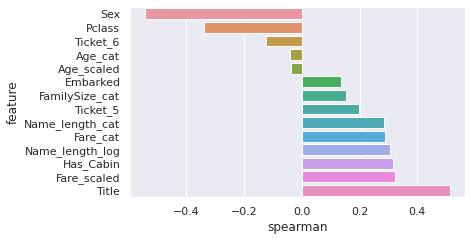

In [34]:
## corrmatrix
def spearman(frame, features):
    spr = pd.DataFrame()
    spr['feature'] = features
    spr['spearman'] = [frame[f].corr(frame['Survived'], 'spearman') for f in features]
    spr = spr.sort_values('spearman')
    plt.figure(figsize=(6, 0.25*len(features)))
    sns.barplot(data=spr, y='feature', x='spearman', orient='h')
    
features = train.drop(['Survived'], axis=1).columns
spearman(train, features)

In [35]:
x = train.drop('Survived', axis=1)
y = train.Survived

In [36]:
# sm = SMOTE(random_state=SEED)
# smk=SMOTETomek(random_state=SEED)
# rus = RandomUnderSampler(random_state=SEED)
ros = RandomOverSampler(random_state=SEED)
# adasyn = ADASYN(random_state=SEED)

x_train, x_valid, y_train, y_valid = train_test_split(x, y, test_size=0.2, random_state=SEED)
x_train, y_train= ros.fit_resample(x_train, y_train)
# x, y= ros.fit_resample(x, y)

**Logistic Regression**

In [37]:
logreg = LogisticRegression(class_weight='balanced', penalty='l1', C=0.5, solver='liblinear')
logreg.fit(x_train, y_train)
acc_log_train = round(logreg.score(x_train, y_train)*100,2) 
acc_log_test = round(logreg.score(x_valid,y_valid)*100,2)
print("Training Accuracy: % {}".format(acc_log_train))
print("Testing Accuracy: % {}".format(acc_log_test))

Training Accuracy: % 82.54
Testing Accuracy: % 78.65


In [38]:
scores = cross_val_score(logreg, x, y, cv=9, scoring = "f1")
print("Scores:", scores)
print("Mean:", scores.mean())
print("Standard Deviation:", scores.std())

Scores: [0.775      0.725      0.7012987  0.81395349 0.76315789 0.70731707
 0.78873239 0.76315789 0.77108434]
Mean: 0.7565224204478672
Standard Deviation: 0.03565549317035314


In [39]:
import eli5 #for purmutation importance

from eli5.sklearn import PermutationImportance

perm = PermutationImportance(logreg, random_state=1).fit(x, y)
eli5.show_weights(perm, feature_names = x.columns.tolist())

/opt/conda/lib/python3.7/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.feature_selection.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_selection. Anything that cannot be imported from sklearn.feature_selection is now part of the private API.
  warnings.warn(message, FutureWarning)


Weight,Feature
0.1599 ± 0.0275,Sex
0.0273 ± 0.0127,FamilySize_cat
0.0239 ± 0.0072,Age_scaled
0.0200 ± 0.0059,Title
0.0140 ± 0.0065,Has_Cabin
0.0027 ± 0.0097,Pclass
0.0018 ± 0.0031,Name_length_log
0.0011 ± 0.0064,Embarked
0 ± 0.0000,Age_cat
-0.0014 ± 0.0022,Ticket_5


**Permutation importance** is one of the first tools for understanding a  model and involves shuffling features in the validation data and seeing the effect on accuracy

**Random Forest Classifier**

In [40]:
from sklearn.model_selection import GridSearchCV
params = {'n_estimators':[70,80,90,100,110],'max_depth': [18,19,20,21,22], 'min_samples_split':[2,3], 'min_samples_leaf':[1,2,3] }
clf_rf = RandomForestClassifier(n_jobs= -1, class_weight='balanced')
grid = GridSearchCV(clf_rf, params, cv=5)
grid.fit(x_train, y_train)
## best params of rf model
grid.best_params_

{'max_depth': 22,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 110}

In [41]:
## best estimator score
best_clf = grid.best_estimator_
best_clf.score(x_valid, y_valid)

0.8089887640449438

In [42]:
## best classifier feature importance list
fi = best_clf.feature_importances_
feature_importance = pd.DataFrame({'importance':fi}, index=x_valid.columns)
feature_importance.sort_values('importance', ascending=False)

,importance
Title,0.167662
Name_length_log,0.143573
Sex,0.136665
Fare_scaled,0.133325
Age_scaled,0.125402
FamilySize_cat,0.060224
Pclass,0.048359
Fare_cat,0.038110
Has_Cabin,0.037720
Age_cat,0.030872


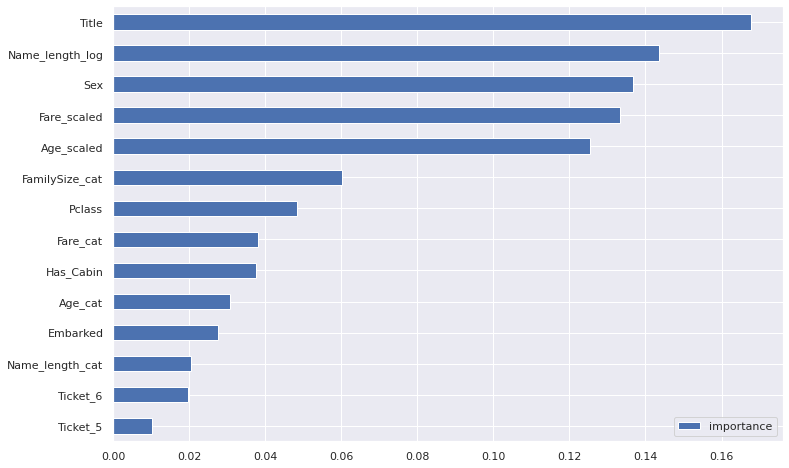

In [43]:
## the same in plot
feature_importance.sort_values('importance').plot(kind='barh', figsize=(12, 8))

In [44]:
## best estimator score for train and validation datasets
acc_rf_train = round(best_clf.score(x_train, y_train)*100,2) 
acc_rf_test = round(best_clf.score(x_valid,y_valid)*100,2)
print("Training Accuracy: % {}".format(acc_rf_train))
print("Testing Accuracy: % {}".format(acc_rf_test))


Training Accuracy: % 99.77
Testing Accuracy: % 80.9


In [45]:
## best cross validation score for random forest
scores = cross_val_score(best_clf, x, y, cv=9, scoring = 'f1')
print("Scores:", scores)
print("Mean:", scores.mean())
print("Standard Deviation:", scores.std())

Scores: [0.72       0.78873239 0.73239437 0.85714286 0.74285714 0.72972973
 0.73846154 0.85714286 0.79487179]
Mean: 0.7734814089743667
Standard Deviation: 0.050898013076584744


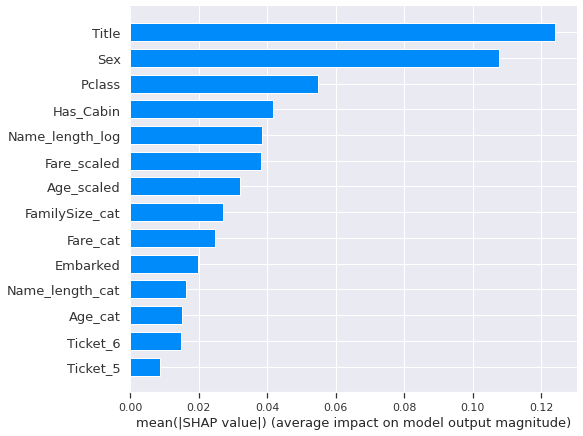

In [46]:
import shap #for SHAP values
explainer = shap.TreeExplainer(best_clf)
shap_values = explainer.shap_values(x_valid)
shap.summary_plot(shap_values[1], x_valid, plot_type="bar")

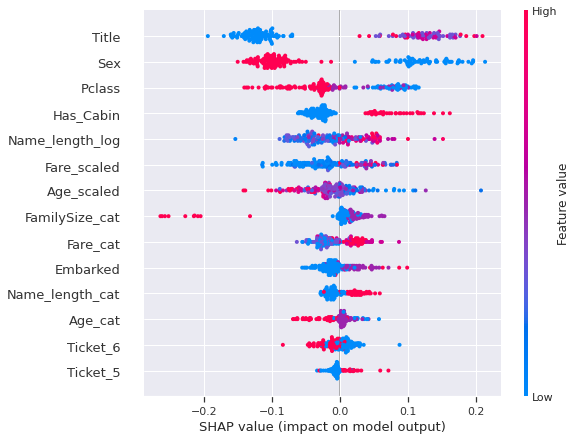

In [47]:
shap.summary_plot(shap_values[1], x_valid)

In [48]:
shap.initjs()
shap_values = explainer.shap_values(x_train.iloc[:50])
shap.force_plot(explainer.expected_value[1], shap_values[1], x_valid.iloc[:50])

In [49]:
from sklearn.model_selection import RandomizedSearchCV
import xgboost as xgb
params = {'n_estimators':[450,500,550,600],'max_depth': [3,4,5,6,7], 'min_child_weight':[1,2,3,4], 'gamma':[0.7,0.8,0,9,1],'subsample':[0.75,0.8,0.85],'colsample_bytree':[0.8,0.85,0.9,0.95] }
clf_xgb = xgb.XGBClassifier(objective="binary:hinge", learning_rate=.1, seed=SEED)
rgrid = RandomizedSearchCV(clf_xgb, params, cv=5)
rgrid.fit(x_train, y_train)

RandomizedSearchCV(cv=5,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, gamma=None,
                                           gpu_id=None, importance_type='gain',
                                           interaction_constraints=None,
                                           learning_rate=0.1,
                                           max_delta_step=None, max_depth=None,
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints=None,
                                           n_estimators=100, n...
                                           random_state=None, reg_alpha=None,
                                           reg_lambda=None,
                                          

In [50]:
rgrid.best_params_

{'subsample': 0.8,
 'n_estimators': 500,
 'min_child_weight': 1,
 'max_depth': 6,
 'gamma': 0.7,
 'colsample_bytree': 0.8}

In [51]:
## best estimator score
best_rclf = rgrid.best_estimator_
best_rclf.score(x_valid, y_valid)

0.8033707865168539

In [52]:
acc_xgb_train = round(best_rclf.score(x_train, y_train)*100,2) 
acc_xgb_test = round(best_rclf.score(x_valid,y_valid)*100,2)
print("Training Accuracy: % {}".format(acc_xgb_train))
print("Testing Accuracy: % {}".format(acc_xgb_test))

Training Accuracy: % 99.77
Testing Accuracy: % 80.34


In [53]:
scores = cross_val_score(best_rclf, x, y, cv=10, scoring = 'f1')
print("Scores:", scores)
print("Mean:", scores.mean())
print("Standard Deviation:", scores.std())

Scores: [0.76056338 0.75757576 0.58064516 0.7826087  0.73239437 0.72463768
 0.76190476 0.8125     0.85714286 0.75      ]
Mean: 0.7519972661204167
Standard Deviation: 0.0680839522678402


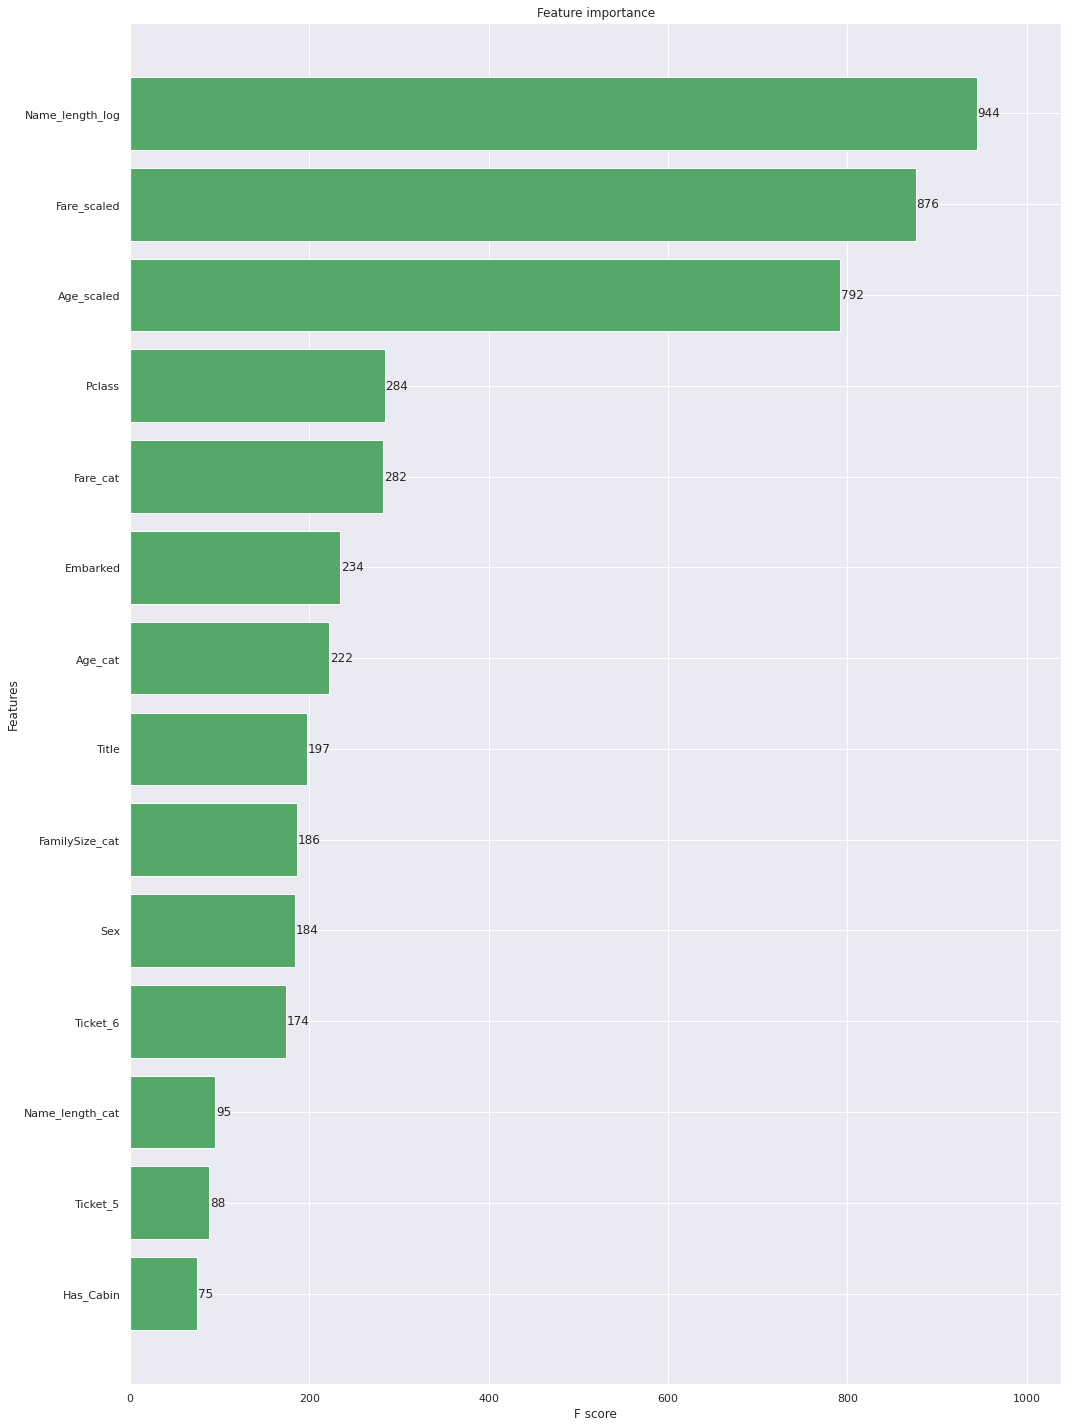

In [54]:
fig,ax = plt.subplots(figsize=(15,20))
xgb.plot_importance(best_rclf,ax=ax,max_num_features=20,height=0.8,color='g')
plt.tight_layout()
plt.show()

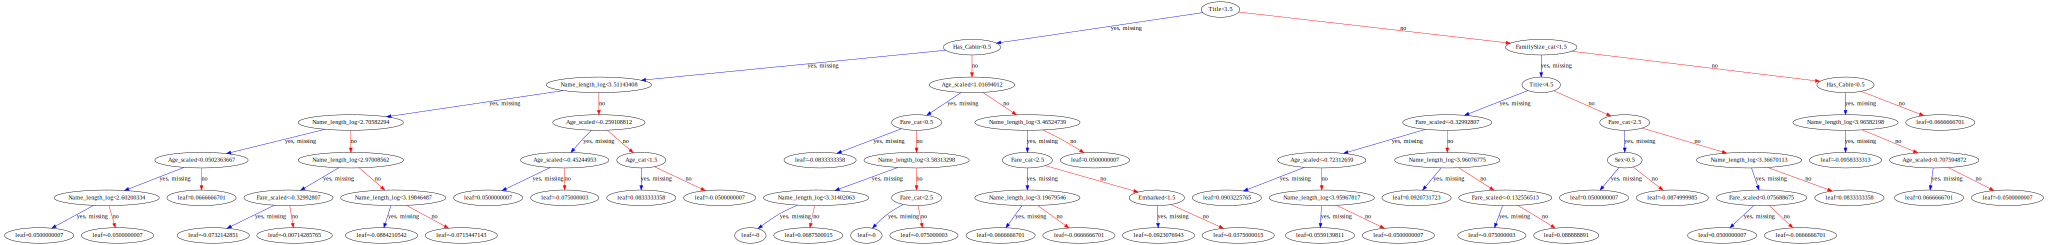

In [55]:
xgb.to_graphviz(best_rclf)
